In [17]:
import torch
import torch.nn as nn
import torch.optim as optim

import tqdm
import pickle
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split

from sklearn.datasets import make_moons
from torchvision import datasets, transforms

from interpolate import interpolate

## Define basic Variational Autoencoder and neessary routines

In [2]:
# variational autoencoder skeleton

class VAE(nn.Module):
    def __init__(self, input_size, num_hidden_layers, hidden_layer_size, bottleneck_size):
        super(VAE, self).__init__()

        # define architecture of the vae
        self.input_size = input_size
        self.num_hidden_layers = num_hidden_layers
        self.hidden_layer_size = hidden_layer_size
        self.bottleneck_size = bottleneck_size
        
        # construct the encoder, and decoder
        self.encoder = self.construct_encoder()
        self.decoder = self.construct_decoder()

        #define loss function and optimizer
        self.mse_loss_function = nn.MSELoss(reduction='mean')
        self.kl_loss_function = nn.KLDivLoss(reduction='mean')

        self.mse_weight = 1000

        self.optimizer = optim.Adam(self.parameters(), lr=0.001)

    def loss_function(self, x, x_hat, mu, log_var):
        # loss function
        mse_loss = self.mse_loss_function(x, x_hat)
        kl_loss = torch.mean(-0.5 * sum(1 + log_var - torch.square(mu) - torch.square(torch.exp(log_var)))) #self.kl_loss_function(mu, log_var)
        return self.mse_weight* mse_loss +  kl_loss

    def construct_encoder(self):
        # construct the encoder
        encoder = nn.Sequential()

        encoder.add_module('input', nn.Linear(self.input_size, self.hidden_layer_size))
        encoder.add_module('relu_input', nn.ReLU())

        for i in range(self.num_hidden_layers - 1):
            encoder.add_module('hidden_' + str(i), nn.Linear(self.hidden_layer_size, self.hidden_layer_size))
            encoder.add_module('relu_' + str(i), nn.ReLU())

        # split output into mu and var components
        #encoder.add_module('mu', nn.Linear(self.hidden_layer_size, self.bottleneck_size))
        #encoder.add_module('log_var', nn.Linear(self.hidden_layer_size, self.bottleneck_size))

        encoder.add_module('bottleneck', nn.Linear(self.hidden_layer_size, self.bottleneck_size*2))

        return encoder
    
    def reparameterise(self, mu, log_var):
        # reparameterise
        std = torch.exp(0.5 * log_var)
        eps = torch.randn_like(std)
        return mu + eps * std
    
    def construct_decoder(self):
        # construct the decoder
        decoder = nn.Sequential()

        decoder.add_module('input', nn.Linear(self.bottleneck_size, self.hidden_layer_size))
        decoder.add_module('relu_input', nn.ReLU())

        for i in range(self.num_hidden_layers - 1):
            decoder.add_module('hidden_' + str(i), nn.Linear(self.hidden_layer_size, self.hidden_layer_size))
            decoder.add_module('relu_' + str(i), nn.ReLU())

        decoder.add_module('output', nn.Linear(self.hidden_layer_size, self.input_size))

        return decoder
    
    def forward(self, x):
        # forward pass
        x = self.encoder(x)
        mu, log_var = torch.chunk(x, 2, dim=-1)
        z = self.reparameterise(mu, log_var)
        x = self.decoder(z)
        return x, mu, log_var
    

In [3]:
# define training loop

def train_vae(model, X_train, X_val, n_epochs=10, batch_size=32, verbose=True):
    loss_history = {
        'train': [],
        'val': []
    }

    if verbose:
        pbar = tqdm.tqdm(range(n_epochs))
    else:
        pbar = range(n_epochs)
    i = 0
    for epoch in pbar:
        i += 1
        # training
        model.train()
        train_loss = 0
        for i in tqdm.tqdm(range(0, X_train.shape[0], batch_size)):
            batch = X_train[i:i+batch_size]
            model.optimizer.zero_grad()
            output, mu, log_var = model(batch)
            loss = model.loss_function(batch, output, mu, log_var)
            loss.backward()
            model.optimizer.step()
            train_loss += loss.item()
        train_loss /= X_train.shape[0]
        loss_history['train'].append(train_loss)

        # validation
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for i in tqdm.tqdm(range(0, X_val.shape[0], batch_size)):
                batch = X_val[i:i+batch_size]
                output, mu, log_var = model(batch)
                loss = model.loss_function(batch, output, mu, log_var)
                val_loss += loss.item()
            val_loss /= X_val.shape[0]
            loss_history['val'].append(val_loss)

        #print loss
        if verbose:
            pbar.set_description('Epoch: {}/{}, train loss: {:.4f}, val loss: {:.4f}'.format(epoch+1, n_epochs, train_loss, val_loss))
        
    return loss_history

In [4]:
# define function to plot loss history

def plot_loss_history(loss_history):
    fig, ax = plt.subplots(1, 1, figsize=(10, 5))

    epochs_linspace = np.linspace(1, len(loss_history['train']), len(loss_history['train']))

    ax.scatter(epochs_linspace, loss_history['train'], label='train loss', marker='o')
    ax.scatter(epochs_linspace, loss_history['val'], label='val loss', marker='x')

    ax.plot(epochs_linspace, loss_history['train'])
    ax.plot(epochs_linspace, loss_history['val'])

    ax.set_xlabel('Epoch')
    ax.set_ylabel('Loss')

    #ax.set_yscale('log')

    ax.grid(alpha=0.35)
    ax.legend()

## Use the VAE for a 2D dataset

In [161]:
# architecture of the vae

INPUT_SIZE = 2
BOTTLENECK_SIZE = 1
HIDDEN_SIZE = 64
HIDDEN_LAYERS = 5

vae_moons = VAE(INPUT_SIZE, HIDDEN_LAYERS, HIDDEN_SIZE, BOTTLENECK_SIZE)

In [130]:
# load data

dataset_size = 5000

dataset = make_moons(n_samples=dataset_size, noise=0.1)[0]

#split into train and val

X_train, X_val = train_test_split(dataset, test_size=0.2)

X_val, X_test = train_test_split(X_val, test_size=0.5)

  0%|          | 0/25 [00:00<?, ?it/s]

0


100%|██████████| 16/16 [00:00<00:00, 1142.84it/s]
Epoch: 1/25, train loss: 10.1967, val loss: 5.4495:   4%|▍         | 1/25 [00:00<00:14,  1.66it/s]

480


100%|██████████| 16/16 [00:00<00:00, 1230.75it/s]
Epoch: 2/25, train loss: 4.8676, val loss: 4.6249:   8%|▊         | 2/25 [00:01<00:13,  1.65it/s] 

480


100%|██████████| 16/16 [00:00<00:00, 1230.77it/s]
Epoch: 3/25, train loss: 4.3502, val loss: 4.4401:  12%|█▏        | 3/25 [00:01<00:13,  1.63it/s]

480


100%|██████████| 16/16 [00:00<00:00, 1142.96it/s]
Epoch: 4/25, train loss: 3.9698, val loss: 3.7361:  16%|█▌        | 4/25 [00:02<00:12,  1.66it/s]

480


100%|██████████| 16/16 [00:00<00:00, 1454.71it/s]
Epoch: 5/25, train loss: 3.8121, val loss: 3.7519:  20%|██        | 5/25 [00:03<00:11,  1.68it/s]

480


100%|██████████| 16/16 [00:00<00:00, 1230.84it/s]
Epoch: 6/25, train loss: 3.6679, val loss: 3.5767:  24%|██▍       | 6/25 [00:03<00:11,  1.68it/s]

480


100%|██████████| 16/16 [00:00<00:00, 1066.10it/s]
Epoch: 7/25, train loss: 3.6965, val loss: 3.5885:  28%|██▊       | 7/25 [00:04<00:11,  1.60it/s]

480


100%|██████████| 16/16 [00:00<00:00, 1230.95it/s]
Epoch: 8/25, train loss: 3.5346, val loss: 3.5452:  32%|███▏      | 8/25 [00:04<00:10,  1.57it/s]

480


100%|██████████| 16/16 [00:00<00:00, 1142.63it/s]
Epoch: 9/25, train loss: 3.5698, val loss: 3.3577:  36%|███▌      | 9/25 [00:05<00:10,  1.54it/s]

480


100%|██████████| 16/16 [00:00<00:00, 1142.80it/s]
Epoch: 10/25, train loss: 3.5628, val loss: 3.4635:  40%|████      | 10/25 [00:06<00:09,  1.54it/s]

480


100%|██████████| 16/16 [00:00<00:00, 1230.63it/s]
Epoch: 11/25, train loss: 3.4679, val loss: 3.3432:  44%|████▍     | 11/25 [00:06<00:09,  1.53it/s]

480


100%|██████████| 16/16 [00:00<00:00, 1230.95it/s]
Epoch: 12/25, train loss: 3.4091, val loss: 3.5166:  48%|████▊     | 12/25 [00:07<00:08,  1.51it/s]

480


100%|██████████| 16/16 [00:00<00:00, 1333.38it/s]
Epoch: 13/25, train loss: 3.4137, val loss: 3.3201:  52%|█████▏    | 13/25 [00:08<00:07,  1.52it/s]

480


100%|██████████| 16/16 [00:00<00:00, 1333.19it/s]
Epoch: 14/25, train loss: 3.3695, val loss: 3.1905:  56%|█████▌    | 14/25 [00:08<00:07,  1.50it/s]

480


100%|██████████| 16/16 [00:00<00:00, 1230.81it/s]
Epoch: 15/25, train loss: 3.3684, val loss: 3.1893:  60%|██████    | 15/25 [00:09<00:06,  1.50it/s]

480


100%|██████████| 16/16 [00:00<00:00, 1333.40it/s]
Epoch: 16/25, train loss: 3.3751, val loss: 3.4113:  64%|██████▍   | 16/25 [00:10<00:05,  1.51it/s]

480


100%|██████████| 16/16 [00:00<00:00, 1142.98it/s]
Epoch: 17/25, train loss: 3.3097, val loss: 3.1247:  68%|██████▊   | 17/25 [00:10<00:05,  1.51it/s]

480


100%|██████████| 16/16 [00:00<00:00, 1142.90it/s]
Epoch: 18/25, train loss: 3.3016, val loss: 3.2416:  72%|███████▏  | 18/25 [00:11<00:04,  1.52it/s]

480


100%|██████████| 16/16 [00:00<00:00, 1454.84it/s]
Epoch: 19/25, train loss: 3.3354, val loss: 3.4026:  76%|███████▌  | 19/25 [00:12<00:03,  1.52it/s]

480


100%|██████████| 16/16 [00:00<00:00, 1142.76it/s]
Epoch: 20/25, train loss: 3.2091, val loss: 3.0956:  80%|████████  | 20/25 [00:12<00:03,  1.51it/s]

480


100%|██████████| 16/16 [00:00<00:00, 1230.95it/s]
Epoch: 21/25, train loss: 3.2122, val loss: 3.2757:  84%|████████▍ | 21/25 [00:13<00:02,  1.51it/s]

480


100%|██████████| 16/16 [00:00<00:00, 1142.78it/s]
Epoch: 22/25, train loss: 3.1922, val loss: 3.1173:  88%|████████▊ | 22/25 [00:14<00:01,  1.52it/s]

480


100%|██████████| 16/16 [00:00<00:00, 1333.48it/s]
Epoch: 23/25, train loss: 3.1327, val loss: 3.1490:  92%|█████████▏| 23/25 [00:14<00:01,  1.51it/s]

480


100%|██████████| 16/16 [00:00<00:00, 1230.77it/s]
Epoch: 24/25, train loss: 3.1678, val loss: 3.2287:  96%|█████████▌| 24/25 [00:15<00:00,  1.53it/s]

480


100%|██████████| 16/16 [00:00<00:00, 1142.94it/s]
Epoch: 25/25, train loss: 3.1837, val loss: 3.2417: 100%|██████████| 25/25 [00:16<00:00,  1.55it/s]


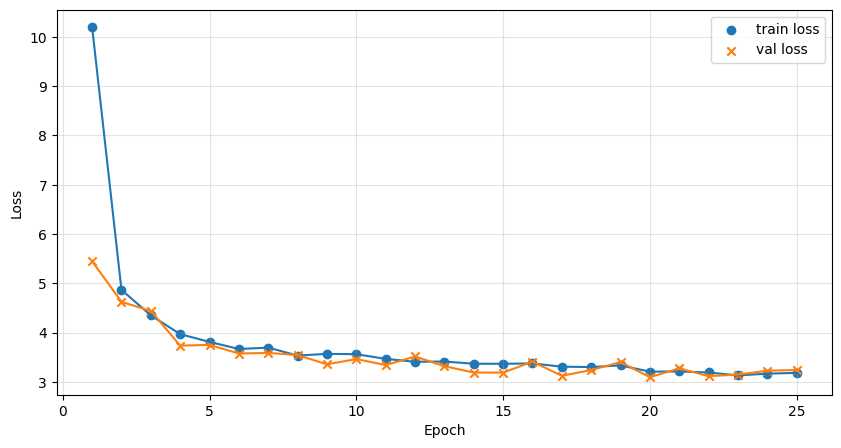

In [162]:
# train the vae

loss_history_moons = train_vae(vae_moons, torch.Tensor(X_train), torch.Tensor(X_val), n_epochs=25, batch_size=32)

# plot loss history

plot_loss_history(loss_history_moons)

Text(0, 0.5, 'y')

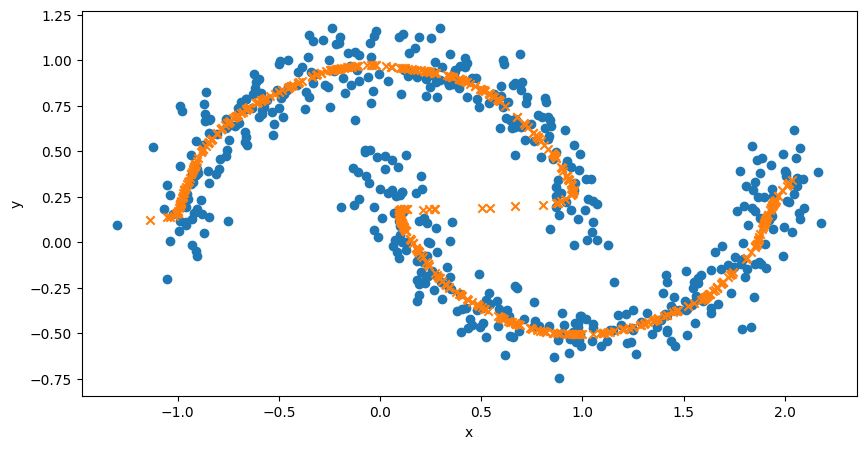

In [163]:
# test reconstruction ability

vae_moons.eval()

with torch.no_grad():
    X_test_recon, _, _ = vae_moons(torch.Tensor(X_test))

fig, ax = plt.subplots(1, 1, figsize=(10, 5))

ax.scatter(X_test[:, 0], X_test[:, 1], label='original', marker='o')
ax.scatter(X_test_recon[:, 0], X_test_recon[:, 1], label='reconstruction', marker='x')

ax.set_xlabel('x')
ax.set_ylabel('y')


## Build Convolutional VAE for MNIST

In [11]:
# construct convolutional vae for mnist data

class ConvVAE(nn.Module):
    def __init__(self, input_size, num_hidden_layers, hidden_layer_size, bottleneck_size):
        super(ConvVAE, self).__init__()

        # define architecture of the vae
        self.input_size = input_size
        self.num_hidden_layers = num_hidden_layers
        self.hidden_layer_size = hidden_layer_size
        self.bottleneck_size = bottleneck_size

        self.mnist_size = 28
        
        # construct the encoder, and decoder
        self.encoder = self.construct_encoder()
        self.decoder = self.construct_decoder()

        #define loss function and optimizer
        self.mse_loss_function = nn.MSELoss(reduction='mean')

        self.mse_weight = 1000

        self.optimizer = optim.Adam(self.parameters(), lr=0.001)

    def loss_function(self, x, x_hat, mu, log_var):
        # loss function
        mse_loss = self.mse_loss_function(x, x_hat)
        kl_loss = torch.mean(-0.5 * sum(1 + log_var - torch.square(mu) - torch.square(torch.exp(log_var)))) #self.kl_loss_function(mu, log_var)
        return self.mse_weight* mse_loss +  kl_loss

    def construct_encoder(self):
        # construct the encoder
        encoder = nn.Sequential()

        encoder.add_module('input', nn.Conv2d(self.input_size, self.hidden_layer_size, kernel_size=3, stride=1, padding=1))
        encoder.add_module('relu_input', nn.ReLU())

        for i in range(self.num_hidden_layers - 1):
            encoder.add_module('hidden_' + str(i), nn.Conv2d(self.hidden_layer_size, self.hidden_layer_size, kernel_size=3, stride=1, padding=1))
            encoder.add_module('relu_' + str(i), nn.ReLU())

        encoder.add_module('flatten', nn.Flatten())
        encoder.add_module('bottleneck', nn.Linear(self.hidden_layer_size * self.mnist_size * self.mnist_size, self.bottleneck_size*2))
        
        return encoder
    
    def reparameterise(self, mu, log_var):
        # reparameterise
        std = torch.exp(0.5 * log_var)
        eps = torch.randn_like(std)
        return mu + eps * std
    
    def construct_decoder(self):
        # construct the decoder
        decoder = nn.Sequential()

        decoder.add_module('input', nn.Linear(self.bottleneck_size, self.hidden_layer_size * self.mnist_size * self.mnist_size))
        decoder.add_module('reshape', nn.Unflatten(1, (self.hidden_layer_size, self.mnist_size, self.mnist_size)))
        decoder.add_module('relu_input', nn.ReLU())

        for i in range(self.num_hidden_layers - 1):
            decoder.add_module('hidden_' + str(i), nn.Conv2d(self.hidden_layer_size, self.hidden_layer_size, kernel_size=3, stride=1, padding=1))
            decoder.add_module('relu_' + str(i), nn.ReLU())

        decoder.add_module('output', nn.Conv2d(self.hidden_layer_size, self.input_size, kernel_size=3, stride=1, padding=1))

        return decoder
    
    def forward(self, x):
        # forward pass
        x = self.encoder(x)
        mu, log_var = torch.chunk(x, 2, dim=-1)
        z = self.reparameterise(mu, log_var)
        x = self.decoder(z)
        return x, mu, log_var
        

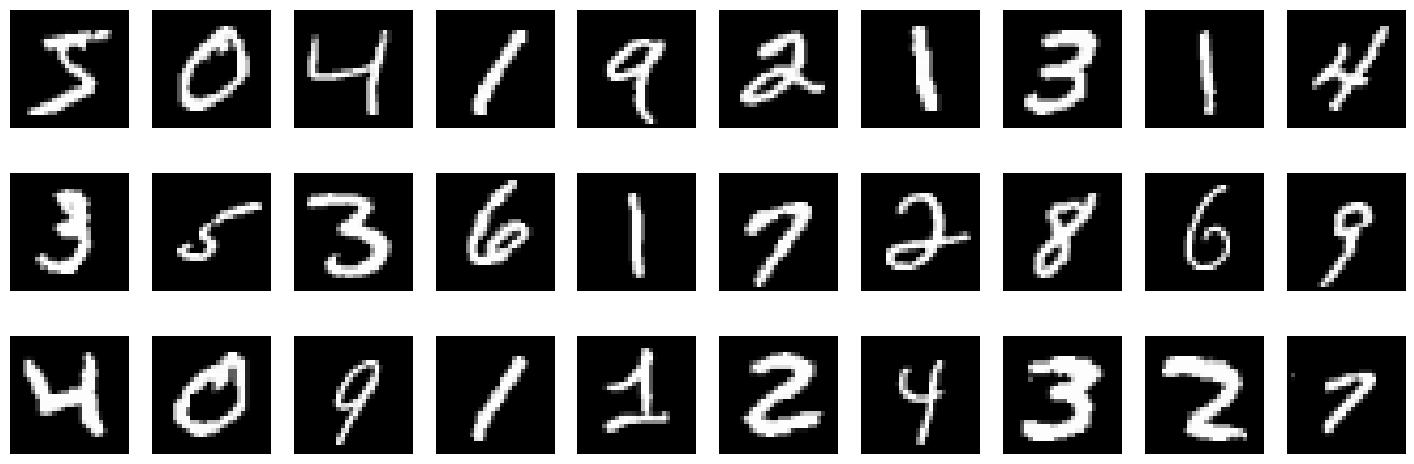

In [12]:
# get MNIST dataset

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

mnist_train_data = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
mnist_test_data = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

mnist_test_data, mnist_val_data = train_test_split(mnist_test_data, test_size=0.5)

mnist_train = torch.stack([x for x, _ in mnist_train_data])
mnist_test = torch.stack([x for x, _ in mnist_test_data])
mnist_val = torch.stack([x for x, _ in mnist_val_data])

mnist_test_labels = torch.Tensor([y for _, y in mnist_test_data])

# visualise data

fig, ax = plt.subplots(3, 10, figsize=(18, 6))

for i in range(3):
    for j in range(10):
        ax[i, j].imshow(mnist_train[i*10 + j].squeeze(), cmap='gray')
        ax[i, j].axis('off')

In [13]:
# train autoencoder on MNIST dataset

INPUT_SIZE = 1
BOTTLENECK_SIZE = 2
HIDDEN_SIZE = 4
HIDDEN_LAYERS = 3

TRAIN = False

if TRAIN:
    conv_vae_mnist = ConvVAE(INPUT_SIZE, HIDDEN_SIZE, HIDDEN_LAYERS, BOTTLENECK_SIZE)
    loss_history_mnist = train_vae(conv_vae_mnist, mnist_train, mnist_val, n_epochs=20, batch_size=32)
    plot_loss_history(loss_history_mnist)
    torch.save(conv_vae_mnist.state_dict(), 'conv_vae_mnist.pt')

else:
    # load pretrained model
    conv_vae_mnist = ConvVAE(INPUT_SIZE, HIDDEN_SIZE, HIDDEN_LAYERS, BOTTLENECK_SIZE)
    conv_vae_mnist.load_state_dict(torch.load('conv_vae_mnist.pt'))

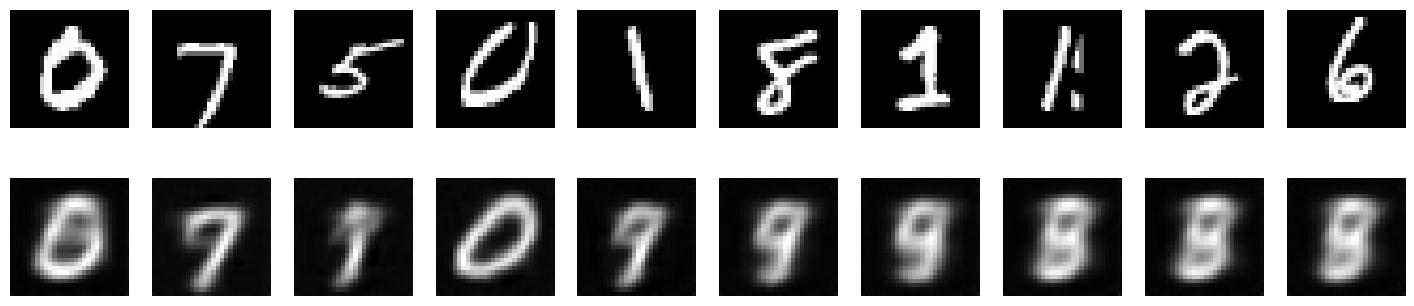

In [14]:
# test reconstruction ability

conv_vae_mnist.eval()

with torch.no_grad():
    mnist_test_recon, _, _ = conv_vae_mnist(mnist_test)

fig, ax = plt.subplots(2, 10, figsize=(18, 4))

for i in range(10):
    ax[0, i].imshow(mnist_test[i].squeeze(), cmap='gray')
    ax[0, i].axis('off')

    ax[1, i].imshow(mnist_test_recon[i].squeeze(), cmap='gray')
    ax[1, i].axis('off')

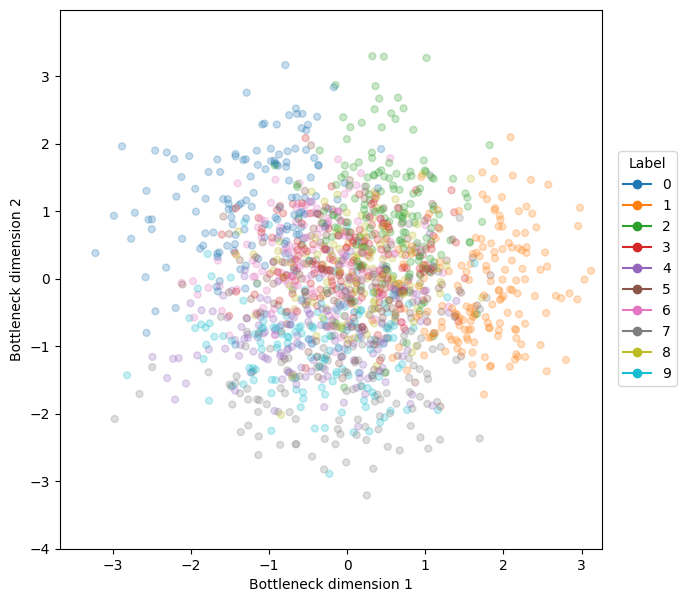

In [15]:
# visualise bottleneck layer with respect to the labels
conv_vae_mnist.eval()

bottleneck_mnist = conv_vae_mnist.encoder(mnist_test)
mu, log_var = torch.chunk(bottleneck_mnist, 2, dim=-1)
bottleneck_mnist = conv_vae_mnist.reparameterise(mu, log_var).detach().numpy()

fig, ax = plt.subplots(1, 1, figsize=(7, 7))

ax.scatter(bottleneck_mnist[:1500, 0], bottleneck_mnist[:1500, 1], c=mnist_test_labels[:1500], cmap='tab10', alpha=0.25, marker='.', s=100)

ax.set_xlabel('Bottleneck dimension 1')
ax.set_ylabel('Bottleneck dimension 2')

legend_handeles = []   
for i in range(10):
    legend_handeles.append(plt.Line2D([0], [0], marker='o', color=plt.cm.tab10.colors[i], label=str(i)))

ax.legend(handles=legend_handeles, title='Label', loc='upper right', bbox_to_anchor=(1.15, 0.75))

ax.set_xlim([np.min(bottleneck_mnist[:, 0]), np.max(bottleneck_mnist[:, 0])])
ax.set_ylim([np.min(bottleneck_mnist[:, 1]), np.max(bottleneck_mnist[:, 1])]);

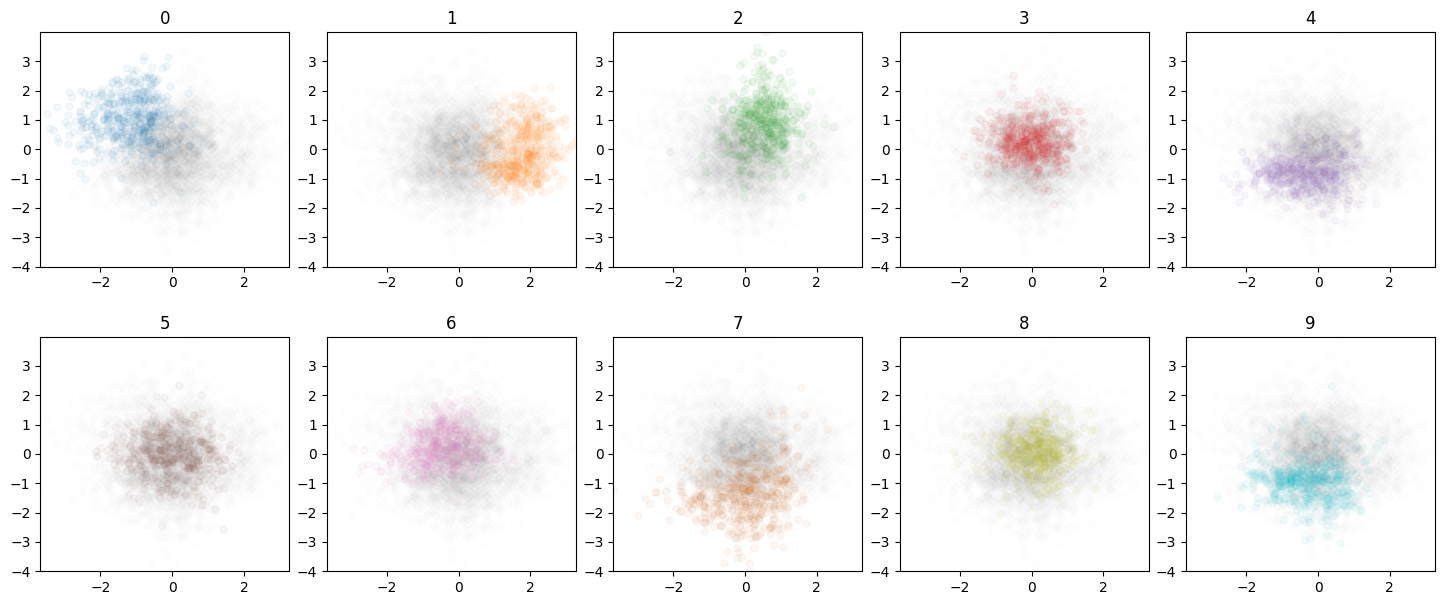

In [16]:
# make subplots for each digit

fig, ax = plt.subplots(2, 5, figsize=(18, 7))

for i in range(10):
    for j in range(10):
        if j != i:
            ax[i//5, i%5].scatter(bottleneck_mnist[mnist_test_labels == j, 0], bottleneck_mnist[mnist_test_labels == j, 1], color='black', alpha=0.005, marker='.', s=100)

    if i != 7:
        ax[i//5, i%5].scatter(bottleneck_mnist[mnist_test_labels == i, 0], bottleneck_mnist[mnist_test_labels == i, 1], color=plt.cm.tab10.colors[i], alpha=0.05, marker='.', s=100)
        ax[i//5, i%5].set_title('{}'.format(i))
    else:
        ax[i//5, i%5].scatter(bottleneck_mnist[mnist_test_labels == i, 0], bottleneck_mnist[mnist_test_labels == i, 1], color='chocolate', alpha=0.05, marker='.', s=100)
        ax[i//5, i%5].set_title('{}'.format(i))

    ax[i//5, i%5].set_xlim([np.min(bottleneck_mnist[:, 0]), np.max(bottleneck_mnist[:, 0])])
    ax[i//5, i%5].set_ylim([np.min(bottleneck_mnist[:, 1]), np.max(bottleneck_mnist[:, 1])])

    fig.subplots_adjust(hspace=0.3)
    fig.subplots_adjust(wspace=0.15)
    

h:\Uni\Master\Semester 2\SciML\SciML-Seminar\interpolate.py:36: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ..\torch\csrc\utils\tensor_new.cpp:264.)
  interpolated_points = torch.Tensor(interpolated_points)
MovieWriter imagemagick unavailable; using Pillow instead.


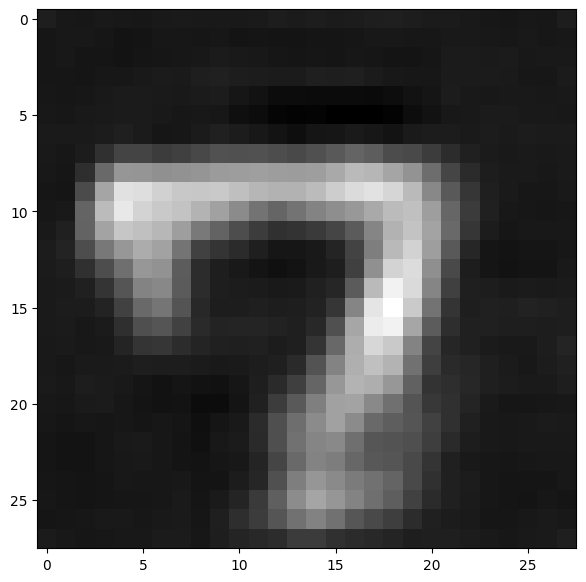

In [18]:
anim = interpolate(conv_vae_mnist, np.array([[-3, -3], [3, 3], [-3, 3], [3, -3], [-3, -3]]), 0.1, name='interpolation_vae.gif')

100%|██████████| 157/157 [00:00<00:00, 380.06it/s]
Epoch: 20/20, train loss: 4.4012, val loss: 4.4600: 100%|██████████| 20/20 [08:01<00:00, 24.08s/it]


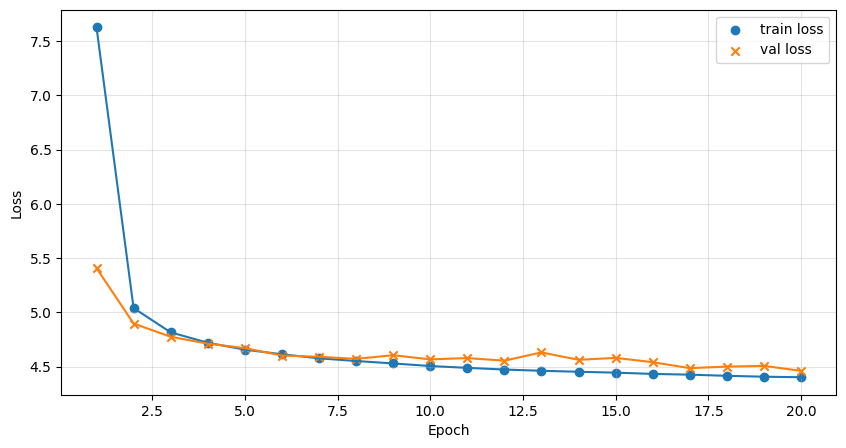

In [19]:
# train vae with bottleneck size 8

INPUT_SIZE = 1
BOTTLENECK_SIZE = 8
HIDDEN_SIZE = 4
HIDDEN_LAYERS = 3

TRAIN = True

if TRAIN:
    conv_vae_mnist_8 = ConvVAE(INPUT_SIZE, HIDDEN_SIZE, HIDDEN_LAYERS, BOTTLENECK_SIZE)
    loss_history_mnist_8 = train_vae(conv_vae_mnist_8, mnist_train, mnist_val, n_epochs=20, batch_size=32)
    plot_loss_history(loss_history_mnist_8)
    torch.save(conv_vae_mnist_8.state_dict(), 'conv_vae_mnist_8.pt')

else:
    # load pretrained model
    conv_vae_mnist_8 = ConvVAE(INPUT_SIZE, HIDDEN_SIZE, HIDDEN_LAYERS, BOTTLENECK_SIZE)
    conv_vae_mnist_8.load_state_dict(torch.load('conv_vae_mnist_8.pt'))

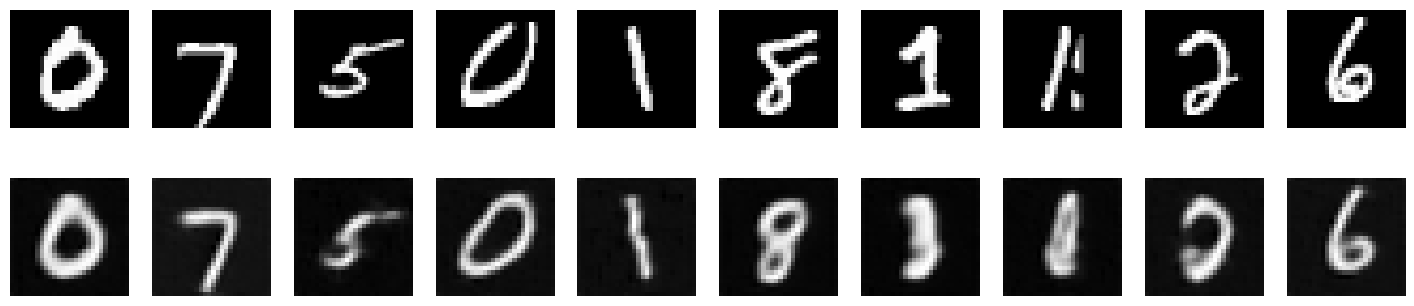

In [20]:
# look at reconstruction ability

conv_vae_mnist_8.eval()

with torch.no_grad():
    mnist_test_recon_8, _, _ = conv_vae_mnist_8(mnist_test)

fig, ax = plt.subplots(2, 10, figsize=(18, 4))

for i in range(10):
    ax[0, i].imshow(mnist_test[i].squeeze(), cmap='gray')
    ax[0, i].axis('off')

    ax[1, i].imshow(mnist_test_recon_8[i].squeeze(), cmap='gray')
    ax[1, i].axis('off')

MovieWriter imagemagick unavailable; using Pillow instead.


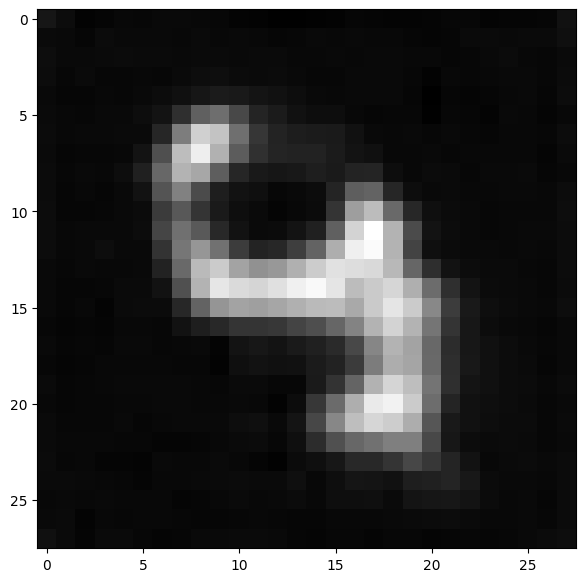

In [21]:
anim = interpolate(conv_vae_mnist_8, np.array([[-1, -1, 1, 1, -1, -1, 1, 1], [-1, 1, 1, -1, -1, 1, 1, -1], [1, 1, 1, 1, 1, 1, 1, 1], [1, -1, 1, 1, 1, -1, 1, 1], [-1, -1, 1, 1, -1, -1, 1, 1]]), 0.1, name='interpolation_vae_8.gif')